In [40]:
import dataprofiler
from ydata_profiling import ProfileReport
import pandas as pd
import json
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, fbeta_score, recall_score, precision_score, root_mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from xgboost import XGBClassifier
import xgboost
%matplotlib inline

In [2]:
df = pd.read_csv('census.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlgt           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.head()

age         workclass   fnlgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country salary  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [5]:
df.tail()

age     workclass   fnlgt   education  education-num  \
32556   27       Private  257302  Assoc-acdm             12   
32557   40       Private  154374     HS-grad              9   
32558   58       Private  151910     HS-grad              9   
32559   22       Private  201490     HS-grad              9   
32560   52  Self-emp-inc  287927     HS-grad              9   

           marital-status         occupation relationship   race     sex  \
32556  Married-civ-spouse       Tech-support         Wife  White  Female   
32557  Married-civ-spouse  Machine-op-inspct      Husband  White    Male   
32558             Widowed       Adm-clerical    Unmarried  White  Female   
32559       Never-married       Adm-clerical    Own-child  White    Male   
32560  Married-civ-spouse    Exec-managerial         Wife  White  Female   

       capital-gain  capital-loss  hours-per-week native-country salary  
32556             0             0              38  United-States  <=50K  
32557             0             0              40  United-States   >50K  
32558             0             0              40  United-States  <=50K  
32559             0             0              20  United-States  <=50K  
32560         15024             0              40  United-States   >50K

In [6]:
df.describe()

age         fnlgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In [7]:
#profile = dataprofiler.Profiler(df)

In [8]:
#readable_report = profile.report(report_options={"output_format": "pretty"})

In [9]:
#data_profile = json.dumps(readable_report, indent=4)

In [10]:
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Dataset has 23 (0.1%) duplicate rows
- Potential feature with capital gain and loss. Lots, of zeros. HasInvestments Yes, No
- Need to check out race and country for imbalances
- 23 duplicate rows check to see if we can drop them
- Lets predict salary level, binarize salary, add HasInvestments feature, 

In [11]:
df.drop_duplicates(inplace = True)

In [12]:

"""label = 'salary'
y= df[label]
X = df.drop(label, axis=1)

cat_features = X.dtypes[df.dtypes=='object'].index
cont_features = X.dtypes[df.dtypes!='object'].index

X_categorical = X[cat_features].values
X_continuous = X.drop(*[cont_features], axis=1)

encoder = OneHotEncoder(handle_unknown="ignore")
lb = LabelBinarizer()

X_cat = encoder.fit_transform(X_categorical)
y = lb.fit_transform(y.values).ravel()

X_tran = np.concatenate([X_continuous, X_categorical], axis=1)

pd.DataFrame(X_tran)"""

'label = \'salary\'\ny= df[label]\nX = df.drop(label, axis=1)\n\ncat_features = X.dtypes[df.dtypes==\'object\'].index\ncont_features = X.dtypes[df.dtypes!=\'object\'].index\n\nX_categorical = X[cat_features].values\nX_continuous = X.drop(*[cont_features], axis=1)\n\nencoder = OneHotEncoder(handle_unknown="ignore")\nlb = LabelBinarizer()\n\nX_cat = encoder.fit_transform(X_categorical)\ny = lb.fit_transform(y.values).ravel()\n\nX_tran = np.concatenate([X_continuous, X_categorical], axis=1)\n\npd.DataFrame(X_tran)'

In [13]:
#manual feature engineering, create my own label and binarize myself
df['investor'] = 1
df['living_wage'] = 1

for i in df.index:
    if df['salary'][i]== '<=50K':
        df.loc[i, 'living_wage'] = 0
    if df['capital-gain'][i] == 0 and df['capital-loss'][i] == 0:
        df.loc[i, 'investor'] = 0

In [14]:
# Get rid of stuff
df.drop(columns=['salary', 'capital-gain', 'capital-loss'], axis=1, inplace=True)

In [15]:
# quick encoding
df = pd.get_dummies(df)

In [16]:
#split train test data
train, test = train_test_split(df, test_size=0.3)

In [17]:
#Get X and y
y_train = train['living_wage']
X_train = train.drop('living_wage', axis=1)

y_test = test['living_wage']
X_test = test.drop('living_wage', axis=1)


In [18]:
def score(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    rmse = root_mean_squared_error(y_test, y_pred)


    print(f"Accuracy: {accuracy}, \nMAE: {mae}, \nF1: {fbeta}, \nPrecision: {precision}, \nRecall: {recall}, \nR2: {rmse}")


In [19]:
# Create model
rfc = RandomForestClassifier(random_state=42)

In [20]:
rfc.fit(X_train, y_train)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [21]:
importances = pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_)
important = importances.nlargest(20)
important.sort_values(ascending=True, inplace=True)
important.plot(kind='barh')

<Axes: >

In [22]:
y_pred = rfc.predict(X_test)

In [23]:
score(y_test, y_pred)

Accuracy: 0.8309772587584512, 
MAE: 0.16902274124154887, 
F1: 0.6236313868613139, 
Precision: 0.672736220472441, 
Recall: 0.5812074829931972, 
R2: 0.41112375416843633


# We will try to find better parameters

In [24]:
grid ={
 'bootstrap': [False],
 'criterion': ['gini', 'entropy', 'logloss'],
 'max_depth': [i for i in range(1,11)],
 'max_features': ['sqrt'],
 'max_leaf_nodes': [i for i in range(1,11)],
 'n_estimators': [i for i in range(1, 251)],
 'n_jobs': [i for i in range(1, 10)],
 'random_state': [i for i in range(1, 101)]
}

In [25]:
rand_search = RandomizedSearchCV(estimator = rfc, param_distributions = grid, cv=3, n_iter=10)

In [26]:
rand_search.fit(X_train, y_train)

/home/swatts/miniconda3/envs/notebook/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/swatts/miniconda3/envs/notebook/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/swatts/miniconda3/envs/notebook/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/swatts/miniconda3/envs/notebook/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validat

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [False],
                                        'criterion': ['gini', 'entropy',
                                                      'logloss'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['sqrt'],
                                        'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...],
                                        'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                                        'random_state': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]})

In [27]:
print(rand_search.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, max_leaf_nodes=8,
                       n_estimators=132, n_jobs=5, random_state=3)


In [28]:
y_pred = rand_search.predict(X_test)

In [29]:
score(y_test, y_pred)

Accuracy: 0.8196066379840197, 
MAE: 0.18039336201598033, 
F1: 0.472912301706076, 
Precision: 0.7987866531850354, 
Recall: 0.3358843537414966, 
R2: 0.42472739729852643


In [30]:

#Best model was default RCF
rfc2 = RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=9, random_state=42)
rfc2.fit(X_train, y_train)
y_pred2 = rfc2.predict(X_test)

score(y_test, y_pred)

Accuracy: 0.8196066379840197, 
MAE: 0.18039336201598033, 
F1: 0.472912301706076, 
Precision: 0.7987866531850354, 
Recall: 0.3358843537414966, 
R2: 0.42472739729852643


In [31]:
rfc2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': 9,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

After going through a couple of hours of hyper tuning, I find the default settings for RandomForest still performs best. therefore I will skip tuning this in the actual piepline. More EDA could probably find biases and other issues. I think it is overkill for this project.

# Will XGBoost work better?

In [41]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)


y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)



In [43]:
score(y_train, y_pred_train)
print("")
score(y_test, y_pred_test)

Accuracy: 0.8951042810098793, 
MAE: 0.10489571899012075, 
F1: 0.770531168955912, 
Precision: 0.8145816409423233, 
Recall: 0.7310005467468562, 
R2: 0.3238760858571079

Accuracy: 0.8435771358328211, 
MAE: 0.15642286416717885, 
F1: 0.6552269135244976, 
Precision: 0.698603755416466, 
Recall: 0.6169217687074829, 
R2: 0.39550330487516644


In [33]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

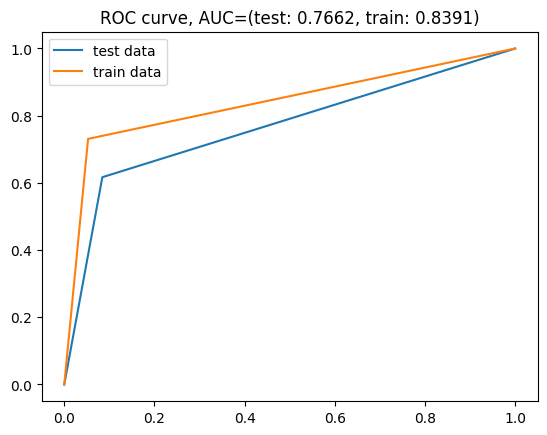

In [47]:
%matplotlib inline
from sklearn import metrics
def buildROC():
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_test)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_train)
    auc_test = metrics.auc(fpr_test, tpr_test)
    auc_train = metrics.auc(fpr_train, tpr_train)    
    plt.title(f"ROC curve, AUC=(test: {auc_test:.4f}, train: {auc_train:.4f})")
    plt.plot(fpr_test, tpr_test, label="test data")
    plt.plot(fpr_train, tpr_train, label="train data")
    plt.legend()
    plt.savefig('ROC.png')
    plt.show()

buildROC()

They both seem to classify the same. Since this is just a quick EDA without using encoders or binarizers and creating a self-made fature, I conclude that XGBoost perfroms slightly better. I will go with this model.

# What does aequitas tell us about the data?

In [34]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
from aequitas import Audit

In [35]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv('census.csv')
df['score'] = 0
df['label_value'] = 1

for i in df.index:
    if df['salary'][i]== '<=50K':
        df.loc[i, 'label_value'] = 0

In [36]:
columns = [
    "score",
    "label_value",
    # "workclass",
    # "education",
    # "marital-status",
    # "occupation",
    # "relationship",
    "race",
    "sex",
    "native-country"
    
]

In [37]:
df = df[columns]
df.to_csv('census_aequitas.csv')
df['label_value'].value_counts()

label_value
0    24720
1     7841
Name: count, dtype: int64

In [38]:
audit = Audit(df,label_column="label_value")
audit.audit()

In [39]:
audit.confusion_matrix

pp     pn  fp    fn     tn  tp  \
attribute_name attribute_value                                              
race           Amer-Indian-Eskimo           0    311   0    36    275   0   
               Asian-Pac-Islander           0   1039   0   276    763   0   
               Black                        0   3124   0   387   2737   0   
               Other                        0    271   0    25    246   0   
               White                        0  27816   0  7117  20699   0   
sex            Female                       0  10771   0  1179   9592   0   
               Male                         0  21790   0  6662  15128   0   
native-country ?                            0    583   0   146    437   0   
               Cambodia                     0     19   0     7     12   0   
               Canada                       0    121   0    39     82   0   
               China                        0     75   0    20     55   0   
               Columbia                     0     59   0     2     57   0   
               Cuba                         0     95   0    25     70   0   
               Dominican-Republic           0     70   0     2     68   0   
               Ecuador                      0     28   0     4     24   0   
               El-Salvador                  0    106   0     9     97   0   
               England                      0     90   0    30     60   0   
               France                       0     29   0    12     17   0   
               Germany                      0    137   0    44     93   0   
               Greece                       0     29   0     8     21   0   
               Guatemala                    0     64   0     3     61   0   
               Haiti                        0     44   0     4     40   0   
               Holand-Netherlands           0      1   0     0      1   0   
               Honduras                     0     13   0     1     12   0   
               Hong                         0     20   0     6     14   0   
               Hungary                      0     13   0     3     10   0   
               India                        0    100   0    40     60   0   
               Iran                         0     43   0    18     25   0   
               Ireland                      0     24   0     5     19   0   
               Italy                        0     73   0    25     48   0   
               Jamaica                      0     81   0    10     71   0   
               Japan                        0     62   0    24     38   0   
               Laos                         0     18   0     2     16   0   
               Mexico                       0    643   0    33    610   0   
               Nicaragua                    0     34   0     2     32   0   
               Outlying-US(Guam-USVI-etc)   0     14   0     0     14   0   
               Peru                         0     31   0     2     29   0   
               Philippines                  0    198   0    61    137   0   
               Poland                       0     60   0    12     48   0   
               Portugal                     0     37   0     4     33   0   
               Puerto-Rico                  0    114   0    12    102   0   
               Scotland                     0     12   0     3      9   0   
               South                        0     80   0    16     64   0   
               Taiwan                       0     51   0    20     31   0   
               Thailand                     0     18   0     3     15   0   
               Trinadad&Tobago              0     19   0     2     17   0   
               United-States                0  29170   0  7171  21999   0   
               Vietnam                      0     67   0     5     62   0   
               Yugoslavia                   0     16   0     6     10   0   

                                           group_label_pos  group_label_neg  \
attribute_name attribute_value      

In [40]:
group = Group()
xtab, _ = group.get_crosstabs(df)

xtab.head(10)

model_id score_threshold  k  attribute_name     attribute_value  accuracy  \
0         0      binary 0/1  0            race  Amer-Indian-Eskimo  0.884244   
1         0      binary 0/1  0            race  Asian-Pac-Islander  0.734360   
2         0      binary 0/1  0            race               Black  0.876120   
3         0      binary 0/1  0            race               Other  0.907749   
4         0      binary 0/1  0            race               White  0.744140   
5         0      binary 0/1  0             sex              Female  0.890539   
6         0      binary 0/1  0             sex                Male  0.694263   
7         0      binary 0/1  0  native-country                   ?  0.749571   
8         0      binary 0/1  0  native-country            Cambodia  0.631579   
9         0      binary 0/1  0  native-country              Canada  0.677686   

   tpr  tnr       for  fdr  fpr  fnr       npv  precision  pp     pn  ppr  \
0  0.0  1.0  0.115756  NaN  0.0  1.0  0.884244        NaN   0    311  NaN   
1  0.0  1.0  0.265640  NaN  0.0  1.0  0.734360        NaN   0   1039  NaN   
2  0.0  1.0  0.123880  NaN  0.0  1.0  0.876120        NaN   0   3124  NaN   
3  0.0  1.0  0.092251  NaN  0.0  1.0  0.907749        NaN   0    271  NaN   
4  0.0  1.0  0.255860  NaN  0.0  1.0  0.744140        NaN   0  27816  NaN   
5  0.0  1.0  0.109461  NaN  0.0  1.0  0.890539        NaN   0  10771  NaN   
6  0.0  1.0  0.305737  NaN  0.0  1.0  0.694263        NaN   0  21790  NaN   
7  0.0  1.0  0.250429  NaN  0.0  1.0  0.749571        NaN   0    583  NaN   
8  0.0  1.0  0.368421  NaN  0.0  1.0  0.631579        NaN   0     19  NaN   
9  0.0  1.0  0.322314  NaN  0.0  1.0  0.677686        NaN   0    121  NaN   

   pprev  fp    fn     tn  tp  group_label_pos  group_label_neg  group_size  \
0    0.0   0    36    275   0               36              275         311   
1    0.0   0   276    763   0              276              763        1039   
2    0.0   0   387   2737   0              387             2737        3124   
3    0.0   0    25    246   0               25              246         271   
4    0.0   0  7117  20699   0             7117            20699       27816   
5    0.0   0  1179   9592   0             1179             9592       10771   
6    0.0   0  6662  15128   0             6662            15128       21790   
7    0.0   0   146    437   0              146              437         583   
8    0.0   0     7     12   0                7               12          19   
9    0.0   0    39     82   0               39               82         121   

   total_entities      prev  
0           32561  0.115756  
1           32561  0.265640  
2           32561  0.123880  
3           32561  0.092251  
4           32561  0.255860  
5           32561  0.109461  
6           32561  0.305737  
7           32561  0.250429  
8           32561  0.368421  
9           32561  0.322314

In [41]:
def get_bias(ref):
    bias = Bias()
    bias_df = bias.get_disparity_predefined_groups(xtab,
                                                   original_df=df,
                                                   ref_groups_dict=ref, #{"race": "White", "sex": "Male", "native-country":"United-States"},
                                                   alpha=0.05,
                                                   mask_significance=True)
    fairness = Fairness()
    fairness_df = fairness.get_group_value_fairness(bias_df)
    overall_fairness = fairness.get_overall_fairness(fairness_df)
    print(overall_fairness)

In [42]:
get_bias({"race": "White", "sex": "Male", "native-country":"United-States"})


{'Unsupervised Fairness': True, 'Supervised Fairness': False, 'Overall Fairness': False}


# Running online version of the auequitas report for the saved dataset. Reference group is White males living in US.

* URL for uploading data: http://aequitas.dssg.io/
* Data stored in same directory as this notbook named "census_aequitas.csv."
* Built from census data, and only including race, sex, and native-country as well as the appropriate label_value derived from salary.
* Score is set to 0.
* Saved report as mhtml and uploaded the html below.



<table>

<tbody>
<tr>
  <td align="left" style=" padding:5px;"><strong>Audit Date:</strong></td>
  <td align="left" style=" padding:5px;">23 Mar 2024</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><strong>Data Audited:</strong></td>
  <td align="left" style=" padding:5px;">32561 rows</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><strong>Attributes Audited:</strong></td>
  <td align="left" style=" padding:5px;">race, sex, native-country</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><strong>Audit Goal(s):</strong></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Equal Parity</a> - Ensure all protected groups are have equal representation in the selected set.</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Proportional Parity</a> - Ensure all protected groups are selected proportional to their percentage of the population.</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Positive Rate Parity</a> - Ensure all protected groups have the same false positive rates as the reference group).</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Discovery Rate Parity</a> - Ensure all protected groups have equally proportional false positives within the selected set (compared to the reference group).</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Negative Rate Parity</a> - Ensure all protected groups have the same false negative rates (as the reference group).</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"></td>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Omission Rate Parity</a> - Ensure all protected groups have equally proportional false negatives within the non-selected set (compared to the reference group).</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><strong>Reference Groups:</strong></td>
  <td align="left" style=" padding:5px;">Custom group - The reference groups you selected for each attribute will be used  to calculate relative disparities in this audit.</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><strong>Fairness Threshold:</strong></td>
  <td align="left" style=" padding:5px;">80%. If disparity for a group is within 80% and 125% of  the value of the reference group on a group metric (e.g. False Positive Rate), this audit will pass.</td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<h3 style="color:#b37d4e;" id="audit-results">Audit Results:</h3>

<ol>
<li><p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#audit-results-summary">Summary</a></p></li>
<li><p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#audit-results-details-by-fairness-measures">Details by Fairness Measures</a></p></li>
<li><p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#audit-results-details-by-protected-attributes">Details by Protected Attributes</a></p></li>
<li><p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#audit-results-bias-metrics-values">Bias Metrics Values</a></p></li>
<li><p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#audit-results-group-metrics-values">Base Metrics Calculated for Each Group</a></p></li>
</ol>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<h3 style="color:#b37d4e;" id="audit-results-summary">Audit Results: Summary</h3>

<table>

<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Equal Parity</a> - Ensure all protected groups are have equal representation in the selected set.</td>
  <td align="left" style=" padding:5px;"><span style="color:green"><b><strong>Passed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#equal-parity-span-green-initpassedspan-green-end">Details</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Proportional Parity</a> - Ensure all protected groups are selected proportional to their percentage of the population.</td>
  <td align="left" style=" padding:5px;"><span style="color:green"><b><strong>Passed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#proportional-parity-span-green-initpassedspan-green-end">Details</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Positive Rate Parity</a> - Ensure all protected groups have the same false positive rates as the reference group).</td>
  <td align="left" style=" padding:5px;"><span style="color:green"><b><strong>Passed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#false-positive-rate-parity-span-green-initpassedspan-green-end">Details</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Discovery Rate Parity</a> - Ensure all protected groups have equally proportional false positives within the selected set (compared to the reference group).</td>
  <td align="left" style=" padding:5px;"><span style="color:green"><b><strong>Passed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#false-discovery-rate-parity-span-green-initpassedspan-green-end">Details</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Negative Rate Parity</a> - Ensure all protected groups have the same false negative rates (as the reference group).</td>
  <td align="left" style=" padding:5px;"><span style="color:green"><b><strong>Passed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#false-negative-rate-parity-span-green-initpassedspan-green-end">Details</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Omission Rate Parity</a> - Ensure all protected groups have equally proportional false negatives within the non-selected set (compared to the reference group).</td>
  <td align="left" style=" padding:5px;"><span style="color:red"><b><strong>Failed</strong></b> </span> </td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#false-omission-rate-parity-span-red-initfailedspan-red-end">Details</a></td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<h3 style="color:#b37d4e;" id="audit-results-details-by-fairness-measures">Audit Results: Details by Fairness Measures</h3>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="equal-parity-span-green-initpassedspan-green-end">Equal Parity: <span style="color:green"><b>Passed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have equal parity is every group is equally represented in the selected set. For example, if race (with possible values of white, black, other) has equal parity, it implies that all three races are equally represented (33% each)in the selected/intervention set.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to intervene equally on people from all races, then you care about this criteria.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><span style="color:green"><b>Based on the fairness threshold used, all groups passed the audit for this metric.</b> </span> </td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="proportional-parity-span-green-initpassedspan-green-end">Proportional Parity: <span style="color:green"><b>Passed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have proportional parity if every group is represented proportionally to their share of the population. For example, if race with possible values of white, black, other being 50%, 30%, 20% of the population respectively) has proportional parity, it implies that all three races are represented in the same proportions (50%, 30%, 20%) in the selected set.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to intervene proportionally on people from all races, then you care about this criteria.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><span style="color:green"><b>Based on the fairness threshold used, all groups passed the audit for this metric.</b> </span> </td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="false-positive-rate-parity-span-green-initpassedspan-green-end">False Positive Rate Parity: <span style="color:green"><b>Passed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have False Positive parity if every group has the same False Positive Error Rate. For example, if race has false positive parity, it implies that all three races have the same False Positive Error Rate.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to make false positive errors equally on people from all races, then you care about this criteria. This is important in cases where your intervention is punitive and has a risk of adverse outcomes for individuals. Using this criteria allows you to make sure that you are not making false positive mistakes about any single group disproportionately.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><span style="color:green"><b>Based on the fairness threshold used, all groups passed the audit for this metric.</b> </span> </td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="false-discovery-rate-parity-span-green-initpassedspan-green-end">False Discovery Rate Parity: <span style="color:green"><b>Passed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have False Discovery Rate parity if every group has the same False Discovery Error Rate. For example, if race has false discovery parity, it implies that all three races have the same False Discvery Error Rate.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to make false positive errors equally on people from all races, then you care about this criteria. This is important in cases where your intervention is punitive and can hurt individuals and where you are selecting a very small group for interventions.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><span style="color:green"><b>Based on the fairness threshold used, all groups passed the audit for this metric.</b> </span> </td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="false-negative-rate-parity-span-green-initpassedspan-green-end">False Negative Rate Parity: <span style="color:green"><b>Passed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have False Negative parity if every group has the same False Negative Error Rate. For example, if race has false negative parity, it implies that all three races have the same False Negative Error Rate.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to make false negative errors equally on people from all races, then you care about this criteria. This is important in cases where your intervention is assistive (providing helpful social services for example) and missing an individual could lead to adverse outcomes for them. Using this criteria allows you to make sure that you’re not missing people from certain groups disproportionately.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><span style="color:green"><b>Based on the fairness threshold used, all groups passed the audit for this metric.</b> </span> </td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="false-omission-rate-parity-span-red-initfailedspan-red-end">False Omission Rate Parity: <span style="color:red"><b>Failed</b> </span> </h4>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left" width="35%">What is it?</th>
  <th align="left">When does it matter?</th>
  <th align="left" width="30%">Which groups failed the audit:</th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px; border: 15px solid white;">This criteria considers an attribute to have False Omission Rate parity if every group has the same False Omission Error Rate. For example, if race has false omission parity, it implies that all three races have the same False Omission Error Rate.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;">If your desired outcome is to make false negative errors equally on people from all races, then you care about this criteria. This is important in cases where your intervention is assistive (providing help social services for example) and missing an individual could lead to adverse outcomes for them , and where you are selecting a very small group for interventions. Using this criteria allows you to make sure that you’re not missing people from certain groups disproportionately.</td>
  <td align="left" style=" padding:5px; border: 15px solid white;"><strong>For race</strong> (with reference group as <strong>White</strong>)<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.12 compared to 0.26 for the reference group White. ">Black</a> with <span style="color:red"><b>0.48X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.09 compared to 0.26 for the reference group White. ">Other</a> with <span style="color:red"><b>0.36X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.12 compared to 0.26 for the reference group White. ">Amer-Indian-Eskimo</a> with <span style="color:red"><b>0.45X</b> </span>  Disparity <br>  <br><strong>For sex</strong> (with reference group as <strong>Male</strong>)<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.11 compared to 0.31 for the reference group Male. ">Female</a> with <span style="color:red"><b>0.36X</b> </span>  Disparity <br>  <br><strong>For native-country</strong> (with reference group as <strong>United-States</strong>)<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.41 compared to 0.25 for the reference group United-States. ">France</a> with <span style="color:red"><b>1.68X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.08 compared to 0.25 for the reference group United-States. ">El-Salvador</a> with <span style="color:red"><b>0.35X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.0 compared to 0.25 for the reference group United-States. ">Holand-Netherlands</a> with <span style="color:red"><b>0.00X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.12 compared to 0.25 for the reference group United-States. ">Jamaica</a> with <span style="color:red"><b>0.50X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.34 compared to 0.25 for the reference group United-States. ">Italy</a> with <span style="color:red"><b>1.39X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.07 compared to 0.25 for the reference group United-States. ">Vietnam</a> with <span style="color:red"><b>0.30X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.38 compared to 0.25 for the reference group United-States. ">Yugoslavia</a> with <span style="color:red"><b>1.53X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.32 compared to 0.25 for the reference group United-States. ">Germany</a> with <span style="color:red"><b>1.31X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.08 compared to 0.25 for the reference group United-States. ">Honduras</a> with <span style="color:red"><b>0.31X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.09 compared to 0.25 for the reference group United-States. ">Haiti</a> with <span style="color:red"><b>0.37X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.11 compared to 0.25 for the reference group United-States. ">Trinadad&amp;Tobago</a> with <span style="color:red"><b>0.43X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.32 compared to 0.25 for the reference group United-States. ">Canada</a> with <span style="color:red"><b>1.31X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.17 compared to 0.25 for the reference group United-States. ">Thailand</a> with <span style="color:red"><b>0.68X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.11 compared to 0.25 for the reference group United-States. ">Laos</a> with <span style="color:red"><b>0.45X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.33 compared to 0.25 for the reference group United-States. ">England</a> with <span style="color:red"><b>1.36X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.06 compared to 0.25 for the reference group United-States. ">Nicaragua</a> with <span style="color:red"><b>0.24X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.03 compared to 0.25 for the reference group United-States. ">Dominican-Republic</a> with <span style="color:red"><b>0.12X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.42 compared to 0.25 for the reference group United-States. ">Iran</a> with <span style="color:red"><b>1.70X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.31 compared to 0.25 for the reference group United-States. ">Philippines</a> with <span style="color:red"><b>1.25X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.39 compared to 0.25 for the reference group United-States. ">Taiwan</a> with <span style="color:red"><b>1.60X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.14 compared to 0.25 for the reference group United-States. ">Ecuador</a> with <span style="color:red"><b>0.58X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.39 compared to 0.25 for the reference group United-States. ">Japan</a> with <span style="color:red"><b>1.57X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.11 compared to 0.25 for the reference group United-States. ">Puerto-Rico</a> with <span style="color:red"><b>0.43X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.03 compared to 0.25 for the reference group United-States. ">Columbia</a> with <span style="color:red"><b>0.14X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.0 compared to 0.25 for the reference group United-States. ">Outlying-US(Guam-USVI-etc)</a> with <span style="color:red"><b>0.00X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.05 compared to 0.25 for the reference group United-States. ">Guatemala</a> with <span style="color:red"><b>0.19X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.11 compared to 0.25 for the reference group United-States. ">Portugal</a> with <span style="color:red"><b>0.44X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.4 compared to 0.25 for the reference group United-States. ">India</a> with <span style="color:red"><b>1.63X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.05 compared to 0.25 for the reference group United-States. ">Mexico</a> with <span style="color:red"><b>0.21X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.06 compared to 0.25 for the reference group United-States. ">Peru</a> with <span style="color:red"><b>0.26X</b> </span>  Disparity<br>   <a data-toggle="tooltip" title="" data-original-title="false omission rate of this group is 0.37 compared to 0.25 for the reference group United-States. ">Cambodia</a> with <span style="color:red"><b>1.50X</b> </span>  Disparity <br>  <br></td>
</tr>
</tbody>
</table>

<p>&nbsp;</p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a> </p>

<p>&nbsp;</p>

<hr>

<h3 style="color:#b37d4e;" id="audit-results-details-by-protected-attributes">Audit Results: Details by Protected Attributes</h3>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="race">race</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Equal Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Proportional Parity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected."> </a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Discovery Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Positive Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Omission Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Negative Rate Parity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Amer-Indian-Eskimo</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Asian-Pac-Islander</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Black</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Other</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">White</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Ref</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="sex">sex</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Equal Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Proportional Parity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected."> </a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Discovery Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Positive Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Omission Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Negative Rate Parity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Female</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Male</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Ref</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="native-country">native-country</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Equal Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the Predicted Positive Group Rate Disparity of each group is within the range allowed by the fairness threshold selected.">Proportional Parity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected."> </a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Discovery Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Discovery Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Positive Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Positive Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Omission Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Omission Rate Parity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected."></a><a data-toggle="tooltip" title="" data-original-title="Fail/Pass test if the False Negative Rate Disparity of each group is within the range allowed by the fairness threshold selected.">False Negative Rate Parity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">?</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cambodia</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Canada</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">China</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Columbia</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Cuba</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Dominican-Republic</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ecuador</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">El-Salvador</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">England</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">France</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Germany</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Greece</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Guatemala</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Haiti</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Holand-Netherlands</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Honduras</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hong</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Hungary</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">India</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Iran</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ireland</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Italy</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Jamaica</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Japan</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Laos</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Mexico</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Nicaragua</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Outlying-US(Guam-USVI-etc)</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Peru</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Philippines</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Poland</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Portugal</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Puerto-Rico</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Scotland</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">South</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Taiwan</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Thailand</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Trinadad&amp;Tobago</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">United-States</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Ref</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Vietnam</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Yugoslavia</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>

<h3 style="color:#b37d4e;" id="audit-results-bias-metrics-values">Audit Results: Bias Metrics Values</h3>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="race-2">race</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Rate of each group divided by the same metric value of the reference group.">Predicted Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Group Ratio of each group divided by the same metric value of the reference group. .">Predicted Positive Group Rate Disparity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="The False Discovery Rate of each group divided by the same metric value of the reference group.">False Discovery Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Positive Rate of each group divided by the same metric value of the reference group.">False Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Omission Rate of each group divided by the same metric value of the reference group.">False Omission Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Negative Rate of each group divided by the same metric value of the reference group.">False Negative Rate Disparity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Amer-Indian-Eskimo</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:red">0.45</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Asian-Pac-Islander</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:green"> 1.04</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Black</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:red">0.48</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Other</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:red">0.36</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">White</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">1.0</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-3">1.0</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="sex-2">sex</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Rate of each group divided by the same metric value of the reference group.">Predicted Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Group Ratio of each group divided by the same metric value of the reference group. .">Predicted Positive Group Rate Disparity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="The False Discovery Rate of each group divided by the same metric value of the reference group.">False Discovery Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Positive Rate of each group divided by the same metric value of the reference group.">False Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Omission Rate of each group divided by the same metric value of the reference group.">False Omission Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Negative Rate of each group divided by the same metric value of the reference group.">False Negative Rate Disparity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Female</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3" style="color:red">0.36</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Male</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">1.0</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-3">1.0</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="native-country-2">native-country</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Rate of each group divided by the same metric value of the reference group.">Predicted Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The Predicted Positive Group Ratio of each group divided by the same metric value of the reference group. .">Predicted Positive Group Rate Disparity</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="The False Discovery Rate of each group divided by the same metric value of the reference group.">False Discovery Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Positive Rate of each group divided by the same metric value of the reference group.">False Positive Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Omission Rate of each group divided by the same metric value of the reference group.">False Omission Rate Disparity</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="The False Negative Rate of each group divided by the same metric value of the reference group.">False Negative Rate Disparity</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">?</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.02</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Cambodia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.5</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Canada</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.31</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">China</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.08</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Columbia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.14</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Cuba</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.07</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Dominican-Republic</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.12</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Ecuador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.58</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">El-Salvador</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.35</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">England</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.36</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">France</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.68</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Germany</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.31</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Greece</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.12</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Guatemala</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.19</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Haiti</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.37</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Holand-Netherlands</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.0</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Honduras</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.31</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Hong</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.22</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Hungary</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 0.94</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">India</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.63</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Iran</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.7</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Ireland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 0.85</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Italy</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.39</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Jamaica</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.5</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Japan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.57</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Laos</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.45</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Mexico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.21</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Nicaragua</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.24</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Outlying-US(Guam-USVI-etc)</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.0</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Peru</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.26</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Philippines</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.25</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Poland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 0.81</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Portugal</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.44</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Puerto-Rico</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.43</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Scotland</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.02</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">South</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 0.81</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Taiwan</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.6</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Thailand</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.68</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Trinadad&amp;Tobago</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.43</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">United-States</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">1.0</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Vietnam</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">0.3</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
<tr>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Yugoslavia</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3">Undefined</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:red">1.53</a></td>
  <td align="left" style=" padding:5px;"><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-3" style="color:green"> 1.0</a></td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>

<h3 style="color:#b37d4e;" id="audit-results-group-metrics-values">Audit Results: Group Metrics Values</h3>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="race-3">race</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left">Group Size Ratio</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the total size of the interventation set.">Predicted Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the size of the group.">Predicted Positive Group Rate</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by the size of the intervention set of the group (predicted positives within group).">False Discovery Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by number of labeled negatives within the group.">False Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negatives of the group divided by the size of the non-selected set of the group (predicted negatives within group).">False Omission Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negative of the group divided by number of labeled positives in the group">False Negative Rate</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;">Amer-Indian-Eskimo</td>
  <td align="left" style=" padding:5px;">0.01</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.12</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Asian-Pac-Islander</td>
  <td align="left" style=" padding:5px;">0.03</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.27</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Black</td>
  <td align="left" style=" padding:5px;">0.1</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.12</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Other</td>
  <td align="left" style=" padding:5px;">0.01</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.09</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">White</td>
  <td align="left" style=" padding:5px;">0.85</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">0.26</td>
  <td align="left" style=" padding:5px;">1.0</td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#race-2">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="sex-3">sex</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left">Group Size Ratio</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the total size of the interventation set.">Predicted Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the size of the group.">Predicted Positive Group Rate</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by the size of the intervention set of the group (predicted positives within group).">False Discovery Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by number of labeled negatives within the group.">False Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negatives of the group divided by the size of the non-selected set of the group (predicted negatives within group).">False Omission Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negative of the group divided by number of labeled positives in the group">False Negative Rate</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;">Female</td>
  <td align="left" style=" padding:5px;">0.33</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.11</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Male</td>
  <td align="left" style=" padding:5px;">0.67</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">0.31</td>
  <td align="left" style=" padding:5px;">1.0</td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#sex-2">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<h4 style="color:#286da8;" id="native-country-3">native-country</h4>

<p>&nbsp;</p>

<table class="table table-striped" padding="5">
<thead>
<tr>
  <th align="left">Attribute Value</th>
  <th align="left">Group Size Ratio</th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the total size of the interventation set.">Predicted Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of elements of the group selected divided by the size of the group.">Predicted Positive Group Rate</a></th>
  <th align="left"> <a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by the size of the intervention set of the group (predicted positives within group).">False Discovery Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false positives of the group divided by number of labeled negatives within the group.">False Positive Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negatives of the group divided by the size of the non-selected set of the group (predicted negatives within group).">False Omission Rate</a></th>
  <th align="left"><a data-toggle="tooltip" title="" data-original-title="Number of false negative of the group divided by number of labeled positives in the group">False Negative Rate</a></th>
</tr>
</thead>
<tbody>
<tr>
  <td align="left" style=" padding:5px;">?</td>
  <td align="left" style=" padding:5px;">0.02</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.25</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Cambodia</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.37</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Canada</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.32</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">China</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.27</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Columbia</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.03</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Cuba</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.26</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Dominican-Republic</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.03</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Ecuador</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.14</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">El-Salvador</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.08</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">England</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.33</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">France</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.41</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Germany</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.32</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Greece</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.28</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Guatemala</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.05</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Haiti</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.09</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Holand-Netherlands</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Honduras</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.08</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Hong</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.3</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Hungary</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.23</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">India</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.4</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Iran</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.42</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Ireland</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.21</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Italy</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.34</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Jamaica</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.12</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Japan</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.39</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Laos</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.11</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Mexico</td>
  <td align="left" style=" padding:5px;">0.02</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.05</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Nicaragua</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.06</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Outlying-US(Guam-USVI-etc)</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Peru</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.06</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Philippines</td>
  <td align="left" style=" padding:5px;">0.01</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.31</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Poland</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.2</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Portugal</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.11</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Puerto-Rico</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.11</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Scotland</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.25</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">South</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:green; padding:10px;"> 0.2</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Taiwan</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.39</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Thailand</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.17</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Trinadad&amp;Tobago</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.11</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">United-States</td>
  <td align="left" style=" padding:5px;">0.9</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">0.25</td>
  <td align="left" style=" padding:5px;">1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Vietnam</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.07</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
<tr>
  <td align="left" style=" padding:5px;">Yugoslavia</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style=" padding:5px;">Undefined</td>
  <td align="left" style=" padding:5px;">0</td>
  <td align="left" style="color:red; padding:10px;">0.38</td>
  <td align="left" style="color:green; padding:10px;"> 1.0</td>
</tr>
</tbody>
</table>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#native-country-2">Go to Previous</a></p>

<p><a href="http://aequitas.dssg.io/audit/h2q0lfis/census_aequitas/report-5.html#">Go to Top</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>

<hr>